In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from scipy import sparse

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.model_selection import StratifiedShuffleSplit

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [2]:
train = pd.read_csv("train.tsv", delimiter = '\t')
test = pd.read_csv("test.tsv", delimiter = '\t')

In [3]:
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
y_train = train['Sentiment']

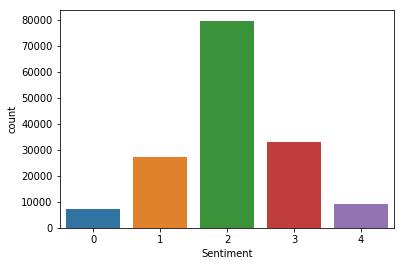

In [6]:
sns.countplot(y_train)

In [7]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [WordNetLemmatizer().lemmatize(w) for w in word_tokenize(doc)]

In [8]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize,sent_tokenize
vectorizer_w = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, stop_words = None,ngram_range = (1,3), analyzer = 'word', encoding = 'utf-8', tokenizer = LemmaTokenizer())
vectorizer_c = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, stop_words = None,ngram_range = (2,6), analyzer = 'char', encoding = 'utf-8', tokenizer = LemmaTokenizer())
X_train_w = vectorizer_w.fit_transform(train['Phrase'])
X_train_c = vectorizer_c.fit_transform(train['Phrase'])
X_test_w = vectorizer_w.transform(test['Phrase'])
X_test_c = vectorizer_c.transform(test['Phrase'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\neloy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\neloy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
X_train = sparse.hstack([X_train_w, X_train_c])
X_test = sparse.hstack([X_test_w, X_test_c])

#Tried Oversampling methods using imbalanced-learn API(http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html)
#However Oversampling did not help
ros = RandomOverSampler(random_state=42)
ada = ADASYN(random_state=152)
#X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
#X_train_ada, y_train_ada = ada.fit_sample(X_train, y_train)

In [10]:
print("Number of samples in Train dataset i.e. n_samples: %d, Number of features in Train dataset i.e. n_features: %d" % X_train.shape)
print("Number of samples in Test dataset i.e. n_samples: %d, Number of features in Test dataset i.e. n_features: %d" % X_test.shape)
print("\n")
#print("Number of samples in Resample Train dataset(Ramdom Sampler) i.e. n_samples: %d, Number of features in Train dataset i.e. n_features: %d" % X_train_ros.shape)
#print("Number of samples in Resample Train dataset(ADASYN) i.e. n_samples: %d, Number of features in Train dataset i.e. n_features: %d" % X_train_ada.shape)

Number of samples in Train dataset i.e. n_samples: 156060, Number of features in Train dataset i.e. n_features: 545680
Number of samples in Test dataset i.e. n_samples: 66292, Number of features in Test dataset i.e. n_features: 545680




In [11]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred_nb = clf.predict(X_test)

In [12]:
submission = pd.read_csv("SampleSubmission.csv",sep='delimiter', header=None)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [13]:
submission.to_csv("submission_NB.csv", index = False)

In [14]:
lclf = LogisticRegression(solver = 'saga',multi_class = 'multinomial', max_iter = 4000, 
                          C = 4, random_state = 42, verbose = 10, class_weight = 'balanced')

#parameters = {'C':[2 , 4] }
#scorer = make_scorer(accuracy_score)
#cv = StratifiedShuffleSplit(2, random_state = 62)
#grid_obj = GridSearchCV(lclf, param_grid=parameters, cv = cv, scoring=scorer, n_jobs=-1, verbose=10)
#grid_fit = grid_obj.fit(X_train, y_train)
#best_clf = grid_fit.best_estimator_

predictions = (lclf.fit(X_train, y_train)).predict(X_test)
#best_predictions = best_clf.predict(X_tes

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 11644 seconds


E:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 194.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 194.1min finished


In [15]:
#Standard NLP Pre-Processing
X_train = train['Phrase']
X_test = test['Phrase']

In [16]:
X_train.head()

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
Name: Phrase, dtype: object

In [17]:
#NORMALIZATION - Converting to lower case
X_train_l = X_train.str.lower()
print(X_train_l[0])
X_train_l.head()

a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

In [18]:
#NORMALIZATION - Removing Punctuation marks
import re
def punc_rem(y):
    return re.sub(r"[^a-zA-Z0-9]", " ", y)
X_train_p = X_train_l.apply(lambda x: punc_rem(x))
print(X_train_p[0])
X_train_p.head()

a series of escapades demonstrating the adage that what is good for the goose is also good for the gander   some of which occasionally amuses but none of which amounts to much of a story  


0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

In [19]:
#TOKENIZATION - Word & Setence tokenizers
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

X_train_wt = X_train_p.apply(lambda x : word_tokenize(x))
X_train_st = X_train_p.apply(lambda x : sent_tokenize(x))

print(X_train_wt[0])
print(X_train_wt.head())
print(X_train_st[0])
print(X_train_st.head())

['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story']
0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Phrase, dtype: object
['a series of escapades demonstrating the adage that what is good for the goose is also good for the gander   some of which occasionally amuses but none of which amounts to much of a story']
0    [a series of escapades demonstrating the adage...
1    [a series of escapades demonstrating the adage...
2                                           [a series]
3                                                 

In [20]:
#STOPWORDS Removal

nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))
def stop_words(x):
    return [i for i in x if i not in stopwords.words('english')]
X_train_sw = X_train_wt.apply(lambda x : stop_words(x))
print(X_train_sw[0])
print(X_train_sw[3])
print(X_train_sw.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neloy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
#POS (Parts Of Speech Tagging) & NER (Named Entity Recognition)

import nltk
nltk.download('averaged_perceptron_tagger')
def postag(x):
    return nltk.pos_tag(x)
X_train_pos = X_train_wt.apply(lambda x: postag(x))
print(X_train_pos[0])
print(X_train_pos[3])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\neloy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('a', 'DT'), ('series', 'NN'), ('of', 'IN'), ('escapades', 'NNS'), ('demonstrating', 'VBG'), ('the', 'DT'), ('adage', 'NN'), ('that', 'IN'), ('what', 'WP'), ('is', 'VBZ'), ('good', 'JJ'), ('for', 'IN'), ('the', 'DT'), ('goose', 'NN'), ('is', 'VBZ'), ('also', 'RB'), ('good', 'JJ'), ('for', 'IN'), ('the', 'DT'), ('gander', 'NN'), ('some', 'DT'), ('of', 'IN'), ('which', 'WDT'), ('occasionally', 'RB'), ('amuses', 'VBZ'), ('but', 'CC'), ('none', 'NN'), ('of', 'IN'), ('which', 'WDT'), ('amounts', 'NNS'), ('to', 'TO'), ('much', 'JJ'), ('of', 'IN'), ('a', 'DT'), ('story', 'NN')]
[('a', 'DT')]


In [22]:
#nltk.help.upenn_tagset('CC')
nltk.download('tagsets')
for i in X_train_pos[0]:
    print("{}: ".format(i))
    (nltk.help.upenn_tagset(i[1]))

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\neloy\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


('a', 'DT'): 
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
('series', 'NN'): 
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
('of', 'IN'): 
IN: preposition or conjunction, subordinating
    astride among uppon whether out inside pro despite on by throughout
    below within for towards near behind atop around if like until below
    next into if beside ...
('escapades', 'NNS'): 
NNS: noun, common, plural
    undergraduates scotches bric-a-brac products bodyguards facets coasts
    divestitures storehouses designs clubs fragrances averages
    subjectivists apprehensions muses factory-jobs ...
('demonstrating', 'VBG'): 
VBG: verb, present participle or gerund
    telegraphing stirring focusing angering judging stalling lactating
    hankeri

In [23]:
nltk.corpus.stopwords.readme() #https://www.nltk.org/book/ch05.html

'Stopwords Corpus\n\nThis corpus contains lists of stop words for several languages.  These\nare high-frequency grammatical words which are usually ignored in text\nretrieval applications.\n\nThey were obtained from:\nhttp://anoncvs.postgresql.org/cvsweb.cgi/pgsql/src/backend/snowball/stopwords/\n\nThe stop words for the Romanian language were obtained from:\nhttp://arlc.ro/resources/\n\nThe English list has been augmented\nhttps://github.com/nltk/nltk_data/issues/22\n\nThe German list has been corrected\nhttps://github.com/nltk/nltk_data/pull/49\n\nA Kazakh list has been added\nhttps://github.com/nltk/nltk_data/pull/52\n\nA Nepali list has been added\nhttps://github.com/nltk/nltk_data/pull/83\n\nAn Azerbaijani list has been added\nhttps://github.com/nltk/nltk_data/pull/100\n\nA Greek list has been added\nhttps://github.com/nltk/nltk_data/pull/103\n\nAn Indonesian list has been added\nhttps://github.com/nltk/nltk_data/pull/112\n'

In [24]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
def ner(x):
    return nltk.ne_chunk(x)

X_train_ner = X_train_pos.apply(lambda x: ner(x))

print(X_train_ner[0])

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\neloy\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\neloy\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  a/DT
  series/NN
  of/IN
  escapades/NNS
  demonstrating/VBG
  the/DT
  adage/NN
  that/IN
  what/WP
  is/VBZ
  good/JJ
  for/IN
  the/DT
  goose/NN
  is/VBZ
  also/RB
  good/JJ
  for/IN
  the/DT
  gander/NN
  some/DT
  of/IN
  which/WDT
  occasionally/RB
  amuses/VBZ
  but/CC
  none/NN
  of/IN
  which/WDT
  amounts/NNS
  to/TO
  much/JJ
  of/IN
  a/DT
  story/NN)


In [25]:
print(nltk.ne_chunk(nltk.pos_tag(word_tokenize("Bangladesh is a great country"))))
#https://www.nltk.org/book/ch07.html

(S (GPE Bangladesh/NNP) is/VBZ a/DT great/JJ country/NN)


In [26]:
#CFG - Context Free Grammer

print(X_train[1])
print(X_train_wt[1])
print(X_train_pos[1])

A series of escapades demonstrating the adage that what is good for the goose
['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']
[('a', 'DT'), ('series', 'NN'), ('of', 'IN'), ('escapades', 'NNS'), ('demonstrating', 'VBG'), ('the', 'DT'), ('adage', 'NN'), ('that', 'IN'), ('what', 'WP'), ('is', 'VBZ'), ('good', 'JJ'), ('for', 'IN'), ('the', 'DT'), ('goose', 'NN')]


In [27]:
nltk.help.upenn_tagset('JJ')

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...


In [28]:
custom_grammer = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP 
VP -> V NP | VP PP | JJ
Det -> 'the'|'a'
N -> 'series'|'escapades'|'adage'|'goose'
V -> 'demonstrating'|'is'
JJ -> 'good'
P -> 'that'|'for'|'of'|'what'
""")

custom_parser = nltk.ChartParser(custom_grammer)
print(custom_parser.parse(X_train_wt[1]))

<generator object Chart.parses at 0x000001B3CFF0D0F8>


In [29]:
help(nltk.ChartParser)

Help on class ChartParser in module nltk.parse.chart:

class ChartParser(nltk.parse.api.ParserI)
 |  A generic chart parser.  A "strategy", or list of
 |  ``ChartRuleI`` instances, is used to decide what edges to add to
 |  the chart.  In particular, ``ChartParser`` uses the following
 |  algorithm to parse texts:
 |  
 |  | Until no new edges are added:
 |  |   For each *rule* in *strategy*:
 |  |     Apply *rule* to any applicable edges in the chart.
 |  | Return any complete parses in the chart
 |  
 |  Method resolution order:
 |      ChartParser
 |      nltk.parse.api.ParserI
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, grammar, strategy=[<nltk.parse.chart.LeafInitRule object at 0x000001B38FB47DD8>, <nltk.parse.chart.EmptyPredictRule object at 0x000001B38FB47E10>, <nltk.parse.chart.BottomUpPredictCombineRule object at 0x000001B38FB47E48>, <nltk.parse.chart.SingleEdgeFundamentalRule object at 0x000001B38FB47E80>], trace=0, trace_chart_width=50, use

In [30]:
for custom_tree in custom_parser.parse(X_train_wt[1]):
    print("Sasikanth")

In [31]:
# Define a custom grammar
my_grammar = nltk.CFG.fromstring("""
S -> NP VP
PP -> P NP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
""")
parser = nltk.ChartParser(my_grammar)

In [32]:
nltk.pos_tag(sentence)

NameError: name 'sentence' is not defined

In [33]:
# Parse a sentence
sentence = word_tokenize("I shot an elephant in my pajamas")
print(type(sentence))
nltk.pos_tag(sentence)
print(parser.parse(sentence))
for tree in parser.parse(sentence):
    print(type(tree))
    print(tree)

<class 'list'>
<generator object Chart.parses at 0x000001B3BE9A9728>
<class 'nltk.tree.Tree'>
(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))
<class 'nltk.tree.Tree'>
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


In [34]:
#STEMMING and LEMMATIZATION
from nltk.stem import porter
stemmer = porter.PorterStemmer()
def stmr(x):
    return [stemmer.stem(i) for i in x]
X_train_stm = X_train_wt.apply(lambda x: stmr(x))
print(X_train_wt[0])
print(X_train_stm[0])

['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story']
['a', 'seri', 'of', 'escapad', 'demonstr', 'the', 'adag', 'that', 'what', 'is', 'good', 'for', 'the', 'goos', 'is', 'also', 'good', 'for', 'the', 'gander', 'some', 'of', 'which', 'occasion', 'amus', 'but', 'none', 'of', 'which', 'amount', 'to', 'much', 'of', 'a', 'stori']


In [35]:
from nltk.stem.wordnet import WordNetLemmatizer
def lmtr(x):
    return [WordNetLemmatizer().lemmatize(i) for i in x]

def lmtrv(x):
    return [WordNetLemmatizer().lemmatize(i, pos = 'v') for i in x]

X_train_lm = X_train_wt.apply(lambda x: lmtr(x))
X_train_lmv = X_train_wt.apply(lambda x: lmtrv(x))

In [36]:
print(X_train_wt[1])
print(X_train_lm[1])
print(X_train_lmv[1])

['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']
['a', 'series', 'of', 'escapade', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']
['a', 'series', 'of', 'escapades', 'demonstrate', 'the', 'adage', 'that', 'what', 'be', 'good', 'for', 'the', 'goose']
